In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

import os
import numpy as np
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable, Union
from tqdm import tqdm

from robustabstain.archs.mininet import MiniNet
from robustabstain.analysis.plotting.plot_revadv_synth import reinit_train_utils
from robustabstain.analysis.plotting.utils.colors import ROBACC_COLORS
from robustabstain.analysis.plotting.utils.decision_region import decision_region_plot_2Ddata
from robustabstain.attacker.wrapper import AttackerWrapper
from robustabstain.data.synth.datasets import SYNTH_DATASETS
from robustabstain.data.synth.plot import plot_synth
from robustabstain.eval.adv import empirical_robustness_eval, get_acc_rob_indicator
from robustabstain.eval.cert import get_acc_cert_indicator
from robustabstain.utils.args_factory import get_full_parser
from robustabstain.utils.datasets import Synth
from robustabstain.utils.checkpointing import get_net
from robustabstain.utils.loaders import get_dataloader
from robustabstain.train.train_adv import train_trades
from robustabstain.train.train_revadv import train_revadv
from robustabstain.train.train_std import train_std
from robustabstain.train.train_gaussaugm import train_gaussaugm
from robustabstain.train.train_revcert import train_revcert
from robustabstain.utils.schedulers import get_lr_scheduler
from robustabstain.utils.helpers import convert_floatstr
from robustabstain.utils.paths import get_root_package_dir
from robustabstain.utils.metrics import AverageMeter, accuracy

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

SEED = 1
def set_seed():
    torch.manual_seed(SEED);
    np.random.seed(SEED);
    
set_seed()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

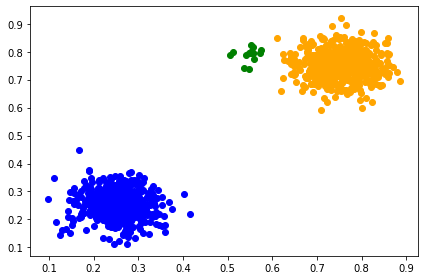

In [4]:
parser = get_full_parser()
dataset = 'threegauss' # the synthetic dataset
train_eps = '0.1'
noise_sd = '0.1'
revadv_beta = '0.2'
LR = 0.03
root_dir = get_root_package_dir()
args = parser.parse_args([
    "--dataset", dataset,
    "--epochs", "20",
    "--adv-norm", "Linf",
    "--train-batch", "10",
    "--adv-norm", "Linf",
    "--train-eps", train_eps,
    "--n-train-samples", "1000",
    "--arch", "mininet",
    "--noise-sd", noise_sd,
    "--smoothing-sigma", noise_sd,
    "--num-noise-vec", "16",
    "--revadv-beta", revadv_beta,
    "--lr", str(LR),
    "--lr-sched", "trades",
    "--test-att-n-steps", "100",
])

set_seed()
train_loader, val_loader, test_loader, _, _, num_classes = get_dataloader(
    args, indexed=True, root_prefix='../', val_set_source='test', val_split=0.0, shuffle_train=True
)
model = get_net('mininet', dataset, 2, device, False, True)

opt = optim.SGD(
    model.parameters(), lr=LR, momentum=args.momentum, weight_decay=args.weight_decay
)
lr_scheduler = get_lr_scheduler(args, args.lr_sched, opt)
criterion = nn.CrossEntropyLoss()
noise_sd = convert_floatstr(args.noise_sd)

plot_synth(
    points=train_loader.dataset.data,
    labels=train_loader.dataset.targets,
    savepath=os.path.join(
        get_root_package_dir(),
        f'analysis/figures/illustration/dataset/{args.dataset}/scatter_plot'
    )
)

# Utils

In [7]:
def savefig(fig: plt.Figure, savepath: str = None):
    fig.savefig(savepath + '.png', dpi=300, bbox_inches="tight")
    fig.savefig(savepath + '.pdf', bbox_inches="tight")
    
def addticks(axs: Union[plt.Axes, List[plt.Axes]], step: float = 0.1) -> None:
    if not isinstance(axs, list) and not isinstance(axs, np.ndarray):
        axs = [axs]
    for ax in axs:
        ax.set_xticks(np.arange(0, 1.1, step=step))
        ax.set_yticks(np.arange(0, 1.1, step=step))
        if step >= 1.0:
            ax.set_xlabel('x1', fontsize=14, labelpad=-4)
            ax.set_ylabel('x2', fontsize=14, labelpad=-4)
        else:
            ax.set_xlabel('x1', fontsize=14, labelpad=4)
            ax.set_ylabel('x2', fontsize=14, labelpad=4)
    
def rmticks(axs: Union[plt.Axes, List[plt.Axes]]) -> None:
    if not isinstance(axs, list) and not isinstance(axs, np.ndarray):
        axs = [axs]
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('x1', fontsize=14, labelpad=4)
        ax.set_ylabel('x2', fontsize=14, labelpad=4)
        
def rmlegend(axs: Union[plt.Axes, List[plt.Axes]]) -> None:
    if not isinstance(axs, list) and not isinstance(axs, np.ndarray):
        axs = [axs]
    for ax in axs:
        ax.legend_ = None
        
def annotate_plot(
        fig: plt.Figure, ax: plt.axes, rob_acc: float, rob_inacc: float,
        savepath: str = None, selector: str = 'ERI', fontsize: int = 25,
        ashift1: int = 0, ashift2: int = 0, rm_annos: bool = True,
        yshift1: float = -0.3, yshift2: float = -0.45
    ) -> Tuple[plt.Annotation, plt.Annotation]:
    """Annotate a decision region plot with abstain model metrics (robust coverage, robust accuracy).
    """
    rob_coverage = round(rob_acc+rob_inacc, 2)
    rob_accuracy = round(100*rob_acc/(rob_acc+rob_inacc), 2)
    
    # annotate metrics over two lines
    anno_v1 = ax.annotate(
        text=' '*ashift1 + f' $\Phi_{{rob}}((F, S_{{{selector}}}), D) = {rob_coverage}\%$',
        xy=(0.5, yshift1), xycoords='axes fraction', fontsize=fontsize, ha='center'
    )
    anno_v2 = ax.annotate(
        text=' '*ashift2 + f'$\mathcal{{A}}_{{rob}}((F, S_{{{selector}}}), D) = {rob_accuracy}\%$', 
        xy=(0.5, yshift2), xycoords='axes fraction', fontsize=fontsize, ha='center'
    )
    if savepath is not None:
        savefig(fig, savepath + '_annov')
    if rm_annos:
        anno_v1.remove()
        anno_v2.remove()

    return anno_v1, anno_v2

def colorblob_metric_legend(ax: plt.Axes, nat_acc: float, rob_acc: float, rob_inacc: float, yshift: float = -0.4) -> matplotlib.legend.Legend:
    nonrob_acc = abs(round(nat_acc - rob_acc, 2))
    nonrob_inacc = abs(round(100 - rob_acc - rob_inacc - nonrob_acc, 2))
    
    annos = [('ra', f"{rob_acc}%"), ('nra', f"{nonrob_acc}%"), ('ria', f"{rob_inacc}%"), ('nria', f"{nonrob_inacc}%")]
    ax_leg = ax.legend(
        [mpatches.Patch(color=ROBACC_COLORS[anno[0]]) for anno in annos],
        [anno[1] for anno in annos],
        loc='lower center', bbox_to_anchor=(0.5, yshift), prop={'size': 15}, ncol=2
    )
    return ax_leg

def readd_class_legend(ax: plt.Axes) -> None:
    markers = ['s', 'v', 'o']
    patch_names = ['0', '1', '2']
    class_leg0 = ax.legend(
        [mlines.Line2D([], [], color='grey', marker=markers[i], linestyle='None', markersize=12) for i in range(3)],
        patch_names, prop={'size': 14}, loc='upper left'
    )

In [8]:
opt = optim.SGD(model.parameters(), lr=0.01, momentum=args.momentum, weight_decay=args.weight_decay)
lr_scheduler = get_lr_scheduler(args, args.lr_sched, opt)
criterion = nn.CrossEntropyLoss()

# Empirical Robustness Abstain Training

## Standard Training

### Train the model using standard training

In [9]:
model_std, opt, lr_scheduler = reinit_train_utils(args, device, num_classes)
model_dir_std = f'../analysis/figures/revadv/{args.dataset}/{args.adv_norm}/{args.train_eps}/{args.arch}/std/'
for epoch in range(20):
    _, _ = train_std(train_loader, model_std, criterion, opt, epoch, device)
    lr_scheduler.step()

[T] STD-TRAIN epoch=0, loss=0.2999, acc1=88.9000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 155.12it/s]
[T] STD-TRAIN epoch=1, loss=0.0787, acc1=98.2000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 156.11it/s]
[T] STD-TRAIN epoch=2, loss=0.0751, acc1=98.4000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 154.59it/s]
[T] STD-TRAIN epoch=3, loss=0.0539, acc1=98.4000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 158.82it/s]
[T] STD-TRAIN epoch=4, loss=0.0578, acc1=98.4000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 152.97it/s]
[T] STD-TRAIN epoch=5, loss=0.0516, acc1=98.4000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 155.62it/s]
[T] STD-TRAIN epoch=6, loss=0.0340, acc1=98.9000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 156.99it/s]
[T] STD-TRAIN epoch=7, loss=0.0237, acc1=99.3000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 153.41it/s]
[T] STD-TRAIN epoch=8, loss=0.0235, acc1=99.4000, acc5=100.0000: 100%|██

### Plot the decision region of the standard trained model

/home/ymerkli/thesis/robust-abstain/robustabstain/utils/data_utils.py:214: UserWarning: Error: no labels file /home/ymerkli/thesis/robust-abstain-icml/robust-abstain/robustabstain/data/labels.csv found.
  warnings.warn(f'Error: no labels file {labels_file} found.')
[V] natural accuracy: acc1=100.0000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 175.93it/s]
[V] adversarial accuracy (pgd Linf eps=0.1): acc1=91.2000, rob_inacc=0.0000: 100%|██████████| 100/100 [00:16<00:00,  6.22it/s]
100%|██████████| 1000/1000 [00:00<00:00, 3006.28it/s]


(Text(0.5, -0.2, ' $\\Phi_{rob}((F, S_{ERI}), D) = 91.2\\%$'),
 Text(0.5, -0.35, '   $\\mathcal{A}_{rob}((F, S_{ERI}), D) = 100.0\\%$'))

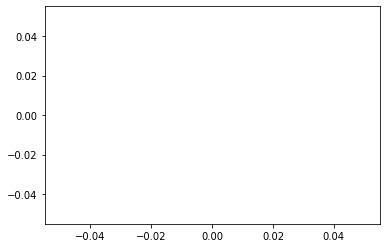

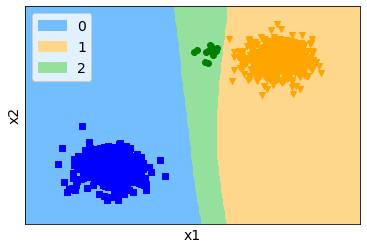

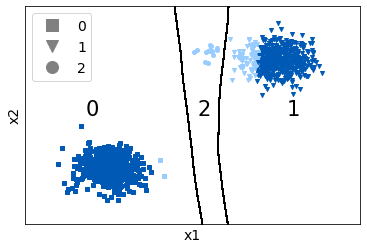

In [11]:
nat_acc_std, rob_acc_std, rob_inacc_std, is_acc_std, is_rob_std, _, _, _, _ = get_acc_rob_indicator(
    args, model_std, model_dir_std, 'mininet', device, train_loader, 'train', args.adv_norm, args.train_eps,
    'pgd', write_report=True
)

# produce plot where class is indicated by color
savepath = os.path.join(model_dir_std, 'color', 'train_std')
fig, ax = decision_region_plot_2Ddata(
    model_std, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='color', is_acc=is_acc_std, is_rob=is_rob_std
)
annotate_plot(fig, ax, rob_acc_std, rob_inacc_std, savepath, ashift2=3, rm_annos=True, yshift1=-0.3, yshift2=-0.45)
addticks(ax, step=1.0)
savefig(fig, savepath+'_lt')
annotate_plot(fig, ax, rob_acc_std, rob_inacc_std, savepath+'_lt', ashift2=3, rm_annos=True, yshift1=-0.25, yshift2=-0.4)
rmticks(ax)
savefig(fig, savepath+'_nt')
annotate_plot(fig, ax, rob_acc_std, rob_inacc_std, savepath+'_nt', ashift2=3, rm_annos=True, yshift1=-0.2, yshift2=-0.35)

# produce plot where class is indicated by shape
savepath = os.path.join(model_dir_std, 'shape', 'train_std')
fig, ax = decision_region_plot_2Ddata(
    model_std, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='shape', is_acc=is_acc_std, is_rob=is_rob_std
)
#NOTE: this annotates the decision surface, the coordinates are NOT adaptive and need to be set by visual inspection
ax.annotate(text='0', xy=(0.2,0.5), xycoords='axes fraction', fontsize=21, ha='center')
ax.annotate(text='1', xy=(0.8,0.5), xycoords='axes fraction', fontsize=21, ha='center')
ax.annotate(text='2', xy=(0.535,0.5), xycoords='axes fraction', fontsize=21, ha='center')
savefig(fig, savepath)
annotate_plot(fig, ax, rob_acc_std, rob_inacc_std, savepath, ashift2=3, rm_annos=True, yshift1=-0.3, yshift2=-0.45)
addticks(ax, step=1.0)
savefig(fig, savepath+'_lt')
annotate_plot(fig, ax, rob_acc_std, rob_inacc_std, savepath+'_lt', ashift2=3, rm_annos=True, yshift1=-0.25, yshift2=-0.4)
rmticks(ax)
savefig(fig, savepath+'_nt')
annotate_plot(fig, ax, rob_acc_std, rob_inacc_std, savepath+'_nt', ashift2=3, rm_annos=True, yshift1=-0.2, yshift2=-0.35)

## TRADES training

### Train the model using TRADES

In [12]:
eps = convert_floatstr(args.train_eps)
model_trades, opt, lr_scheduler = reinit_train_utils(args, device, num_classes)
model_dir_trades = f'../analysis/figures/revadv/{args.dataset}/{args.adv_norm}/{args.train_eps}/{args.arch}/adv/'
for epoch in range(args.epochs):
    _, _, _ = train_trades(args, model_trades, device, train_loader, opt, eps, epoch)
    lr_scheduler.step()

[T] TRADES epoch=0, trades_loss=0.7326, nat_loss=0.6446, nat_acc1=83.4000, adv_acc1=81.5000 (eps=0.1000), rob_inacc=14.8000: 100%|██████████| 100/100 [00:02<00:00, 35.96it/s]
[T] TRADES epoch=1, trades_loss=0.5617, nat_loss=0.4824, nat_acc1=81.3000, adv_acc1=76.9000 (eps=0.1000), rob_inacc=16.5000: 100%|██████████| 100/100 [00:02<00:00, 37.27it/s]
[T] TRADES epoch=2, trades_loss=0.3714, nat_loss=0.2121, nat_acc1=95.4000, adv_acc1=94.9000 (eps=0.1000), rob_inacc=4.5000: 100%|██████████| 100/100 [00:02<00:00, 36.43it/s]
[T] TRADES epoch=3, trades_loss=0.5200, nat_loss=0.4175, nat_acc1=90.9000, adv_acc1=86.3000 (eps=0.1000), rob_inacc=8.4000: 100%|██████████| 100/100 [00:02<00:00, 35.95it/s]
[T] TRADES epoch=4, trades_loss=0.1475, nat_loss=0.1104, nat_acc1=98.4000, adv_acc1=98.3000 (eps=0.1000), rob_inacc=1.5000: 100%|██████████| 100/100 [00:02<00:00, 35.24it/s] 
[T] TRADES epoch=5, trades_loss=0.0972, nat_loss=0.0846, nat_acc1=98.4000, adv_acc1=98.4000 (eps=0.1000), rob_inacc=1.6000: 100

### Plot the decision region of the TRADES trained model

/home/ymerkli/thesis/robust-abstain/robustabstain/utils/data_utils.py:214: UserWarning: Error: no labels file /home/ymerkli/thesis/robust-abstain-icml/robust-abstain/robustabstain/data/labels.csv found.
  warnings.warn(f'Error: no labels file {labels_file} found.')
[V] natural accuracy: acc1=98.4000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 187.81it/s]
[V] adversarial accuracy (pgd Linf eps=0.1): acc1=98.4000, rob_inacc=1.6000: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]
100%|██████████| 1000/1000 [00:00<00:00, 3057.41it/s]


(Text(0.5, -0.2, '  $\\Phi_{rob}((F, S_{ERI}), D) = 100.0\\%$'),
 Text(0.5, -0.35, '$\\mathcal{A}_{rob}((F, S_{ERI}), D) = 98.4\\%$'))

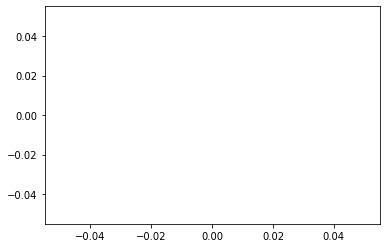

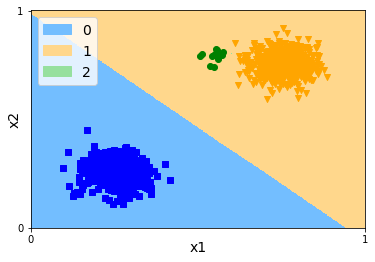

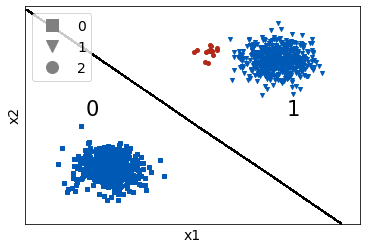

In [13]:
nat_acc_trades, rob_acc_trades, rob_inacc_trades, is_acc_trades, is_rob_trades, _, _, _, _ = get_acc_rob_indicator(
    args, model_trades, model_dir_trades, 'mininet', device, train_loader,
    'train', args.adv_norm, args.train_eps, 'pgd', write_report=True
)

# produce plot where class is indicated by color
savepath = os.path.join(model_dir_trades, 'color', 'train_trades')
fig, ax = decision_region_plot_2Ddata(
    model_trades, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='color', is_acc=is_acc_trades, is_rob=is_rob_trades
)
annotate_plot(fig, ax, rob_acc_trades, rob_inacc_trades, savepath, ashift1=1, rm_annos=True, yshift1=-0.3, yshift2=-0.45)
rmticks(ax)
savefig(fig, savepath+'_nt')
annotate_plot(fig, ax, rob_acc_trades, rob_inacc_trades, savepath+'_nt', ashift1=1, rm_annos=True, yshift1=-0.25, yshift2=-0.4)
addticks(ax, step=1.0)
savefig(fig, savepath+'_lt')
annotate_plot(fig, ax, rob_acc_trades, rob_inacc_trades, savepath+'_lt', ashift1=1, rm_annos=True, yshift1=-0.2, yshift2=-0.35)

# produce plot where class is indicated by shape
savepath = os.path.join(model_dir_trades, 'shape', 'train_trades')
fig, ax = decision_region_plot_2Ddata(
    model_trades, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='shape', is_acc=is_acc_trades, is_rob=is_rob_trades
)
ax.annotate(text='0', xy=(0.2,0.5), xycoords='axes fraction', fontsize=21, ha='center')
ax.annotate(text='1', xy=(0.8,0.5), xycoords='axes fraction', fontsize=21, ha='center')
savefig(fig, savepath)
annotate_plot(fig, ax, rob_acc_trades, rob_inacc_trades, savepath, ashift1=1, rm_annos=True, yshift1=-0.3, yshift2=-0.45)
addticks(ax, step=1.0)
savefig(fig, savepath+'_lt')
annotate_plot(fig, ax, rob_acc_trades, rob_inacc_trades, savepath+'_lt', ashift1=1, rm_annos=True, yshift1=-0.25, yshift2=-0.4)
rmticks(ax)
savefig(fig, savepath+'_nt')
annotate_plot(fig, ax, rob_acc_trades, rob_inacc_trades, savepath+'_nt', ashift1=1, rm_annos=True, yshift1=-0.2, yshift2=-0.35)

## ERI Abstain Training

### Train the model using our proposed abstain training method (ERI)

In [15]:
model_mrevadv, opt, lr_scheduler = reinit_train_utils(args, device, num_classes)
model_dir_mrevadv = f'../analysis/figures/revadv/{args.dataset}/{args.adv_norm}/{args.train_eps}/{args.arch}/mrevadv/'
for epoch in range(20):
    _, _, _, _, _, _ = train_revadv(args, model_mrevadv, device, train_loader, opt, epoch, beta=0.2, soft=True, variant='mrevadv')
    lr_scheduler.step()

[T] REVADV epoch=0, loss=0.5844, nat_acc1=63.8000, adv_acc1=59.5000 (eps=0.1), nonrob=19.8000, rob_inacc=20.7000: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s]
[T] REVADV epoch=1, loss=0.0619, nat_acc1=98.4000, adv_acc1=97.2000 (eps=0.1), nonrob=2.0000, rob_inacc=0.8000: 100%|██████████| 100/100 [00:02<00:00, 36.89it/s]
[T] REVADV epoch=2, loss=0.0708, nat_acc1=98.3000, adv_acc1=95.6000 (eps=0.1), nonrob=3.6000, rob_inacc=0.8000: 100%|██████████| 100/100 [00:02<00:00, 36.33it/s]
[T] REVADV epoch=3, loss=0.0572, nat_acc1=98.4000, adv_acc1=97.9000 (eps=0.1), nonrob=1.4000, rob_inacc=0.7000: 100%|██████████| 100/100 [00:02<00:00, 36.72it/s]
[T] REVADV epoch=4, loss=0.0407, nat_acc1=98.4000, adv_acc1=98.3000 (eps=0.1), nonrob=1.2000, rob_inacc=0.5000: 100%|██████████| 100/100 [00:02<00:00, 35.12it/s]
[T] REVADV epoch=5, loss=0.0376, nat_acc1=98.4000, adv_acc1=98.1000 (eps=0.1), nonrob=1.6000, rob_inacc=0.3000: 100%|██████████| 100/100 [00:02<00:00, 35.98it/s] 
[T] REVADV epoch=6, loss=

### Plot the decision region of the ERI trained model

/home/ymerkli/thesis/robust-abstain/robustabstain/utils/data_utils.py:214: UserWarning: Error: no labels file /home/ymerkli/thesis/robust-abstain-icml/robust-abstain/robustabstain/data/labels.csv found.
  warnings.warn(f'Error: no labels file {labels_file} found.')
[V] natural accuracy: acc1=98.4000, acc5=100.0000: 100%|██████████| 100/100 [00:00<00:00, 175.47it/s]
[V] adversarial accuracy (pgd Linf eps=0.1): acc1=98.4000, rob_inacc=0.0000: 100%|██████████| 100/100 [00:16<00:00,  6.14it/s]
100%|██████████| 1000/1000 [00:00<00:00, 3142.52it/s]


(Text(0.5, -0.2, ' $\\Phi_{rob}((F, S_{ERI}), D) = 98.4\\%$'),
 Text(0.5, -0.35, '   $\\mathcal{A}_{rob}((F, S_{ERI}), D) = 100.0\\%$'))

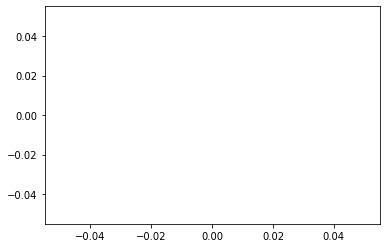

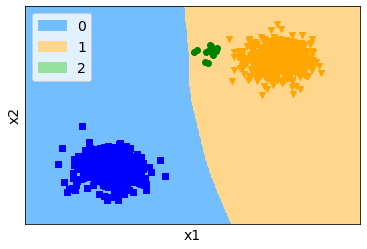

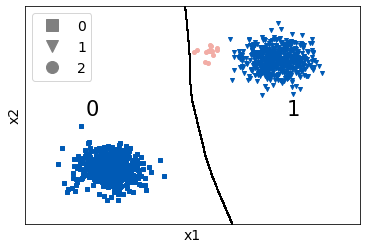

In [16]:
nat_acc_mrevadv, rob_acc_mrevadv, rob_inacc_mrevadv, is_acc_mrevadv, is_rob_mrevadv, _, _, _, _ = get_acc_rob_indicator(
    args, model_mrevadv, model_dir_mrevadv, 'mininet', device, train_loader,
    'train', args.adv_norm, args.train_eps, 'pgd', write_report=True
)
# produce plot where class is indicated by color
savepath = os.path.join(model_dir_mrevadv, 'color', 'train_mrevadv')
fig, ax = decision_region_plot_2Ddata(
    model_mrevadv, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='color', is_acc=is_acc_mrevadv, is_rob=is_rob_mrevadv
)
annotate_plot(fig, ax, rob_acc_mrevadv, rob_inacc_mrevadv, savepath, ashift2=3, rm_annos=True, yshift1=-0.3, yshift2=-0.45)
addticks(ax, step=1.0)
savefig(fig, savepath+'_lt')
annotate_plot(fig, ax, rob_acc_mrevadv, rob_inacc_mrevadv, savepath+'_lt', ashift2=3, rm_annos=True, yshift1=-0.25, yshift2=-0.4)
rmticks(ax)
savefig(fig, savepath+'_nt')
annotate_plot(fig, ax, rob_acc_mrevadv, rob_inacc_mrevadv, savepath+'_nt', ashift2=3, rm_annos=True, yshift1=-0.2, yshift2=-0.35)

# produce plot where class is indicated by shape
savepath = os.path.join(model_dir_mrevadv, 'shape', 'train_mrevadv')
fig, ax = decision_region_plot_2Ddata(
    model_mrevadv, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='shape', is_acc=is_acc_mrevadv, is_rob=is_rob_mrevadv
)
#NOTE: this annotates the decision surface, the coordinates are NOT adaptive and need to be set by visual inspection
ax.annotate(text='0', xy=(0.2,0.5), xycoords='axes fraction', fontsize=21, ha='center')
ax.annotate(text='1', xy=(0.8,0.5), xycoords='axes fraction', fontsize=21, ha='center')
savefig(fig, savepath)
annotate_plot(fig, ax, rob_acc_mrevadv, rob_inacc_mrevadv, savepath, ashift2=3, rm_annos=True, yshift1=-0.3, yshift2=-0.45)
addticks(ax, step=1.0)
savefig(fig, savepath+'_lt')
annotate_plot(fig, ax, rob_acc_mrevadv, rob_inacc_mrevadv, savepath+'_lt', ashift2=3, rm_annos=True, yshift1=-0.25, yshift2=-0.4)
rmticks(ax)
savefig(fig, savepath+'_nt')
annotate_plot(fig, ax, rob_acc_mrevadv, rob_inacc_mrevadv, savepath+'_nt', ashift2=3, rm_annos=True, yshift1=-0.2, yshift2=-0.35)

## Joint Plot

100%|██████████| 1000/1000 [00:00<00:00, 3177.45it/s]


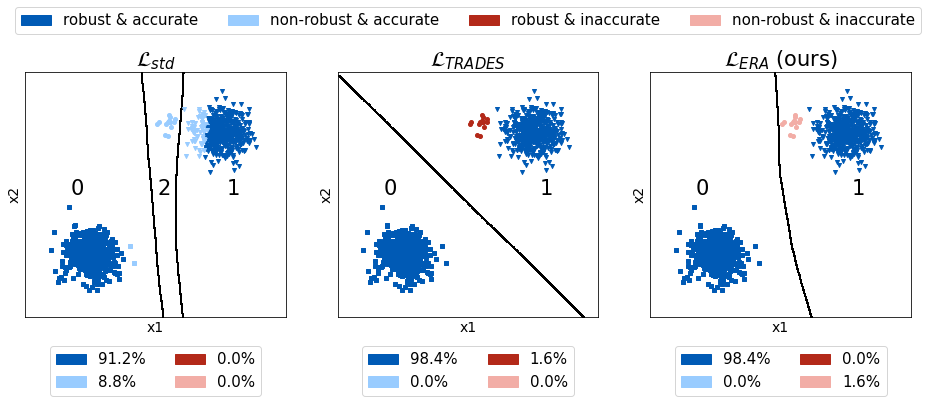

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.tight_layout()
plot_width, plot_height = 14, 4
fig.set_size_inches(plot_width, plot_height)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
subtitle_fontsize = 21
model_dir_joint = f'../analysis/figures/revadv/{args.dataset}/{args.adv_norm}/{args.train_eps}/{args.arch}/'
    
# plot std trained model
ax_idx = 0
decision_region_plot_2Ddata(
    model_std, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='shape', is_acc=is_acc_std, is_rob=is_rob_std, ax=axs[ax_idx], set_ticks=False
)
axs[ax_idx].set_title(r"$\mathcal{L}_{std}$", fontsize=subtitle_fontsize)
#NOTE: this annotates the decision surface, the coordinates are NOT adaptive and need to be set by visual inspection
axs[ax_idx].annotate(text='0', xy=(0.2,0.5), xycoords='axes fraction', fontsize=21, ha='center')
axs[ax_idx].annotate(text='1', xy=(0.8,0.5), xycoords='axes fraction', fontsize=21, ha='center')
axs[ax_idx].annotate(text='2', xy=(0.535,0.5), xycoords='axes fraction', fontsize=21, ha='center')

# plot trades trained model
ax_idx = 1
decision_region_plot_2Ddata(
    model_trades, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='shape', is_acc=is_acc_trades, is_rob=is_rob_trades, ax=axs[ax_idx], set_ticks=False
)
axs[ax_idx].set_title(r"$\mathcal{L}_{TRADES}$", fontsize=subtitle_fontsize)
#NOTE: this annotates the decision surface, the coordinates are NOT adaptive and need to be set by visual inspection
axs[ax_idx].annotate(text='0', xy=(0.2,0.5), xycoords='axes fraction', fontsize=21, ha='center')
axs[ax_idx].annotate(text='1', xy=(0.8,0.5), xycoords='axes fraction', fontsize=21, ha='center')

# plot mrevadv trained model
ax_idx = 2
decision_region_plot_2Ddata(
    model_mrevadv, device, data=train_loader.dataset.data, data_labels=train_loader.dataset.targets,
    savepath=savepath, version='shape', is_acc=is_acc_mrevadv, is_rob=is_rob_mrevadv, ax=axs[ax_idx], set_ticks=False
)
axs[ax_idx].set_title(r"$\mathcal{L}_{ERA}$ (ours)", fontsize=subtitle_fontsize)
#NOTE: this annotates the decision surface, the coordinates are NOT adaptive and need to be set by visual inspection
axs[ax_idx].annotate(text='0', xy=(0.2,0.5), xycoords='axes fraction', fontsize=21, ha='center')
axs[ax_idx].annotate(text='1', xy=(0.8,0.5), xycoords='axes fraction', fontsize=21, ha='center')

# create legend
annos = [('ra', 'robust & accurate'), ('nra', 'non-robust & accurate'), ('ria', 'robust & inaccurate'), ('nria', 'non-robust & inaccurate')]
fig_leg = fig.legend(
    [mpatches.Patch(color=ROBACC_COLORS[anno[0]]) for anno in annos],
    [anno[1] for anno in annos],
    loc='upper center', bbox_to_anchor=(0.5175, 1.2), prop={'size': 15}, ncol=4
)

# save figure
savepath = os.path.join(model_dir_joint, 'train_joint')
addticks(axs)
savefig(fig, savepath)
addticks(ax, step=1.0)
savefig(fig, savepath+'_lt')
rmticks(axs)
savefig(fig, savepath+'_nt')

# add accuracy annotations
anno_fontsize = 18
addticks(axs)
anno_std1, anno_std2 = annotate_plot(fig, axs[0], rob_acc_std, rob_inacc_std, savepath=None, fontsize=anno_fontsize, ashift2=3, rm_annos=False, yshift1=-0.25, yshift2=-0.4)
anno_trades1, anno_trades2 = annotate_plot(fig, axs[1], rob_acc_trades, rob_inacc_trades, savepath=None, fontsize=anno_fontsize, ashift1=1, rm_annos=False, yshift1=-0.25, yshift2=-0.4)
annotate_plot(fig, axs[2], rob_acc_mrevadv, rob_inacc_mrevadv, savepath, fontsize=anno_fontsize, ashift2=4, rm_annos=True, yshift1=-0.25, yshift2=-0.4)
anno_std1.remove()
anno_std2.remove()
anno_trades1.remove()
anno_trades2.remove()
color_leg0 = colorblob_metric_legend(axs[0], nat_acc_std, rob_acc_std, rob_inacc_std, yshift=-0.4)
color_leg1 = colorblob_metric_legend(axs[1], nat_acc_trades, rob_acc_trades, rob_inacc_trades, yshift=-0.4)
color_leg2 = colorblob_metric_legend(axs[2], nat_acc_mrevadv, rob_acc_mrevadv, rob_inacc_mrevadv, yshift=-0.4)
# matplotlib removes old legend once new legend is plotted
readd_class_legend(axs[0])
readd_class_legend(axs[1])
readd_class_legend(axs[2])
axs[0].add_artist(color_leg0)
axs[1].add_artist(color_leg1)
axs[2].add_artist(color_leg2)
savefig(fig, savepath+'_coloranno')
rmlegend(axs)
color_leg0.remove()
color_leg1.remove()
color_leg2.remove()

addticks(axs, step=1.0)
readd_class_legend(axs[0])
readd_class_legend(axs[1])
readd_class_legend(axs[2])
anno_std1, anno_std2 = annotate_plot(fig, axs[0], rob_acc_std, rob_inacc_std, savepath=None, fontsize=anno_fontsize, ashift2=3, rm_annos=False, yshift1=-0.25, yshift2=-0.35)
anno_trades1, anno_trades2 = annotate_plot(fig, axs[1], rob_acc_trades, rob_inacc_trades, savepath=None, fontsize=anno_fontsize, ashift1=1, rm_annos=False, yshift1=-0.25, yshift2=-0.35)
annotate_plot(fig, axs[2], rob_acc_mrevadv, rob_inacc_mrevadv, savepath+'_lt', fontsize=anno_fontsize, ashift2=3, rm_annos=True, yshift1=-0.25, yshift2=-0.35)
anno_std1.remove()
anno_std2.remove()
anno_trades1.remove()
anno_trades2.remove()
color_leg0 = colorblob_metric_legend(axs[0], nat_acc_std, rob_acc_std, rob_inacc_std, yshift=-0.4)
color_leg1 = colorblob_metric_legend(axs[1], nat_acc_trades, rob_acc_trades, rob_inacc_trades, yshift=-0.4)
color_leg2 = colorblob_metric_legend(axs[2], nat_acc_mrevadv, rob_acc_mrevadv, rob_inacc_mrevadv, yshift=-0.4)
# matplotlib removes old legend once new legend is plotted
readd_class_legend(axs[0])
readd_class_legend(axs[1])
readd_class_legend(axs[2])
axs[0].add_artist(color_leg0)
axs[1].add_artist(color_leg1)
axs[2].add_artist(color_leg2)
savefig(fig, savepath+'_lt_coloranno')
rmlegend(axs)
color_leg0.remove()
color_leg1.remove()
color_leg2.remove()

rmticks(axs)
readd_class_legend(axs[0])
readd_class_legend(axs[1])
readd_class_legend(axs[2])
anno_std1, anno_std2 = annotate_plot(fig, axs[0], rob_acc_std, rob_inacc_std, savepath=None, fontsize=anno_fontsize, ashift2=3, rm_annos=False, yshift1=-0.2, yshift2=-0.3)
anno_trades1, anno_trades2 = annotate_plot(fig, axs[1], rob_acc_trades, rob_inacc_trades, savepath=None, fontsize=anno_fontsize, ashift1=1, rm_annos=False, yshift1=-0.2, yshift2=-0.3)
annotate_plot(fig, axs[2], rob_acc_mrevadv, rob_inacc_mrevadv, savepath+'_nt', fontsize=anno_fontsize, ashift2=4, rm_annos=True, yshift1=-0.2, yshift2=-0.3)
anno_std1.remove()
anno_std2.remove()
anno_trades1.remove()
anno_trades2.remove()
color_leg0 = colorblob_metric_legend(axs[0], nat_acc_std, rob_acc_std, rob_inacc_std, yshift=-0.35)
color_leg1 = colorblob_metric_legend(axs[1], nat_acc_trades, rob_acc_trades, rob_inacc_trades, yshift=-0.35)
color_leg2 = colorblob_metric_legend(axs[2], nat_acc_mrevadv, rob_acc_mrevadv, rob_inacc_mrevadv, yshift=-0.35)
# matplotlib removes old legend once new legend is plotted
readd_class_legend(axs[0])
readd_class_legend(axs[1])
readd_class_legend(axs[2])
axs[0].add_artist(color_leg0)
axs[1].add_artist(color_leg1)
axs[2].add_artist(color_leg2)
savefig(fig, savepath+'_nt_coloranno')
rmlegend(axs)